# Sentiment Analysis of Stock Twits with VADER

### Import libs

In [1]:
#### NLP LIBS ###
import nltk
import numpy as np
import pandas as pd
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Import utils function ###
from utils import get_tweets_from_db, eval_model, URI, DB_NAME
from cleaning_utils import full_preprocess

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\humic\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Get Tweets from MongoDB database (`db_tweets.META`)

In [2]:
# Retrieve data from MongoDB
data_from_mongodb = get_tweets_from_db(uri=URI, db_name=DB_NAME, collection_name="AAPL")

# Create DataFrame from retrieved data
df_meta_tweets = pd.DataFrame(data_from_mongodb)

df_meta_tweets

,_id,date,content,true_sentiment
0,662691526f6491024e22dd9f,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None
1,662691536f6491024e22dda1,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish
2,662691536f6491024e22dda3,2024-04-22T16:26:43Z,$AAPL cnbc guy says sees another 5% down bit h...,None
3,662691546f6491024e22dda5,2024-04-22T16:26:06Z,$AAPL look for a move to the downside in the s...,bullish
4,662691556f6491024e22dda7,2024-04-22T16:24:16Z,Hey $AAPL $CMCSA &amp; $GOOG you can have my $...,None
...,...,...,...,...
137,662691d86f6491024e22deb1,2024-04-22T15:12:24Z,$AAPL 140,bearish
138,662691d86f6491024e22deb3,2024-04-22T15:12:07Z,$AAPL Y&#39;all were supposed to sell at 200. ...,bullish
139,662691e26f6491024e22deb5,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None
140,662691e46f6491024e22deb7,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish


### Data preprocessing

- replace the hashtags
- remove stopwords and useless punctuation

In [3]:
df_meta_tweets["cleaned_content"] = df_meta_tweets["content"].apply(full_preprocess)
df_meta_tweets

,_id,date,content,true_sentiment,cleaned_content
0,662691526f6491024e22dd9f,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None,cashtag nice dip quicki
1,662691536f6491024e22dda1,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish,cashtag fuck sweatshop
2,662691536f6491024e22dda3,2024-04-22T16:26:43Z,$AAPL cnbc guy says sees another 5% down bit h...,None,cashtag cnbc guy say see anoth 5 % bit ha buy ...
3,662691546f6491024e22dda5,2024-04-22T16:26:06Z,$AAPL look for a move to the downside in the s...,bullish,cashtag look move downsid short term howev exp...
4,662691556f6491024e22dda7,2024-04-22T16:24:16Z,Hey $AAPL $CMCSA &amp; $GOOG you can have my $...,None,hey cashtag cashtag cashtag cashtag cash stock
...,...,...,...,...,...
137,662691d86f6491024e22deb1,2024-04-22T15:12:24Z,$AAPL 140,bearish,cashtag 140
138,662691d86f6491024e22deb3,2024-04-22T15:12:07Z,$AAPL Y&#39;all were supposed to sell at 200. ...,bullish,cashtag suppos sell 200 buy mfkin dip earn bad...
139,662691e26f6491024e22deb5,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None,cashtag nice dip quicki
140,662691e46f6491024e22deb7,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish,cashtag fuck sweatshop


## Compute sentiment score with VADER algorithm

In [4]:
sid = SentimentIntensityAnalyzer()

def compute_sentiment_score_VADER(tweet):
    scores = sid.polarity_scores(tweet)
    sentiment_dict = {'tweet':tweet, 'bullish_score': scores['pos'], 'bearish_score': scores['neg'], 'neutral_score': scores['neu'], 'compound_score': scores['compound']}
    return sentiment_dict

list_dict = list()

for tweet in df_meta_tweets["content"]:
    sentiment = compute_sentiment_score_VADER(tweet)
    list_dict.append(sentiment) 

df_sentiment = pd.DataFrame(list_dict)
df_sentiment

,tweet,bullish_score,bearish_score,neutral_score,compound_score
0,$AAPL nice dip quickies $$$$$$$$$$$$$,0.412,0.000,0.588,0.4215
1,$AAPL fucking sweatshops,0.000,0.000,1.000,0.0000
2,$AAPL cnbc guy says sees another 5% down bit h...,0.145,0.000,0.855,0.5994
3,$AAPL look for a move to the downside in the s...,0.076,0.084,0.840,-0.0516
4,Hey $AAPL $CMCSA &amp; $GOOG you can have my $...,0.000,0.000,1.000,0.0000
...,...,...,...,...,...
137,$AAPL 140,0.000,0.000,1.000,0.0000
138,$AAPL Y&#39;all were supposed to sell at 200. ...,0.203,0.000,0.797,0.5927
139,$AAPL nice dip quickies $$$$$$$$$$$$$,0.412,0.000,0.588,0.4215
140,$AAPL fucking sweatshops,0.000,0.000,1.000,0.0000


#### Post-Processing: Compute the predicted label
* `bullish`
* `bearish`

In [5]:
df_meta_tweets["predicted_sentiment"] = df_sentiment.apply(lambda row: 'bearish' if row['compound_score'] <= -0.5 else 'bullish', axis=1)
df_meta_tweets

,_id,date,content,true_sentiment,cleaned_content,predicted_sentiment
0,662691526f6491024e22dd9f,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None,cashtag nice dip quicki,bullish
1,662691536f6491024e22dda1,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish,cashtag fuck sweatshop,bullish
2,662691536f6491024e22dda3,2024-04-22T16:26:43Z,$AAPL cnbc guy says sees another 5% down bit h...,None,cashtag cnbc guy say see anoth 5 % bit ha buy ...,bullish
3,662691546f6491024e22dda5,2024-04-22T16:26:06Z,$AAPL look for a move to the downside in the s...,bullish,cashtag look move downsid short term howev exp...,bullish
4,662691556f6491024e22dda7,2024-04-22T16:24:16Z,Hey $AAPL $CMCSA &amp; $GOOG you can have my $...,None,hey cashtag cashtag cashtag cashtag cash stock,bullish
...,...,...,...,...,...,...
137,662691d86f6491024e22deb1,2024-04-22T15:12:24Z,$AAPL 140,bearish,cashtag 140,bullish
138,662691d86f6491024e22deb3,2024-04-22T15:12:07Z,$AAPL Y&#39;all were supposed to sell at 200. ...,bullish,cashtag suppos sell 200 buy mfkin dip earn bad...,bullish
139,662691e26f6491024e22deb5,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None,cashtag nice dip quicki,bullish
140,662691e46f6491024e22deb7,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish,cashtag fuck sweatshop,bullish


### Model Evaluation

To evaluate the model performance prediction we compute the confusion matrix and the classification report

C:\Users\humic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\humic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\humic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


######## Classification Report ########

              precision    recall  f1-score   support

        None       0.00      0.00      0.00        79
     bearish       0.22      0.14      0.17        14
     bullish       0.35      0.94      0.51        49

    accuracy                           0.34       142
   macro avg       0.19      0.36      0.23       142
weighted avg       0.14      0.34      0.19       142

######## Accuracy Score ########
0.34



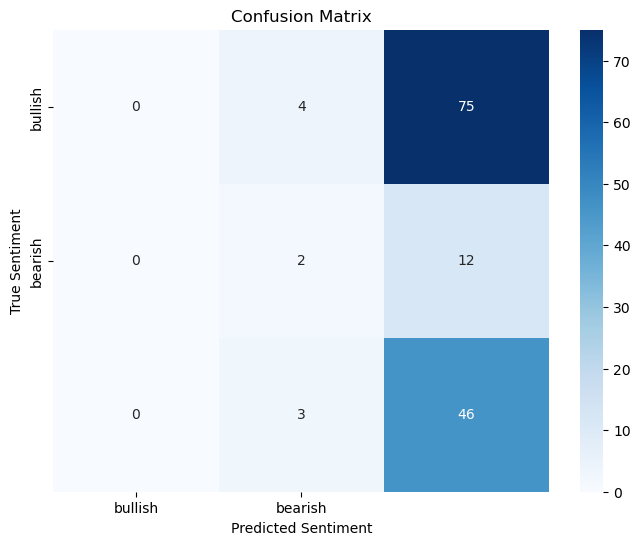

In [6]:
eval_model(df_meta_tweets["true_sentiment"], df_meta_tweets["predicted_sentiment"])

#### Store the predicted sentiment into a new MongoDB Collection

In [7]:
## TO DO